In [1]:
from SPR_run import SPR_Analysis
import os
import numpy as np
from tqdm import tqdm

7.6 GB is free of total 7.9 GB


In [2]:
def delay(time : np.ndarray, sig : np.ndarray) -> float : 
    """
    delay return the time delay of the signal

    Parameters
    ----------
    time : np.ndarray
        _description_
    sig : np.ndarray
        _description_

    Returns
    -------
    float
        _description_
    """    
    return time[np.argmax(abs(sig))]

In [3]:
def delay_dispersion(time, signal) -> float: 
    """
    delay_dispersion return the dispersion of the signal given a threshold 1/e * max(signal)

    Parameters
    ----------
    time : np.ndarray
        _description_
    signal : np.ndarray
        _description_

    Returns
    -------
    float
        _description_
    """    
    mask = np.abs(signal) > np.exp(-1) * np.max(np.abs(signal))
    time_window = time[mask]
    
    return (time_window[-1] - time_window[0]) / 2 

In [4]:
SPRA = SPR_Analysis(config_path='config.json')


In [5]:
amplitude = np.logspace(-2,0, 20)

In [6]:
folder='./output' #output folder
if not os.path.exists(folder):
    os.makedirs(folder)
for amp in amplitude:    
    fname=folder+"/a_{:.4f}".format(amp)
    if not os.path.exists(fname):
        os.makedirs(fname)

In [7]:
os.environ['PATH'] = '/usr/local/cuda/bin:/usr/local/gcc/7.2.0/bin'

In [8]:
_ = 0 * SPRA.generate_global_density()
SPRA.run(_)
np.save(folder+'/indicator.npy', [SPRA.time_list, SPRA.IQ])
IQ_0 = SPRA.IQ

In [9]:
for amp in tqdm(amplitude, desc='amplitudes loop', leave=False) : 
    
    SPRA.CONSTANTS['physics_constant']['amp'] = amp
    
    for n in range(5) : 
        gaussian_field = SPRA.generate_global_density()
        
        SPRA.run(gaussian_field)
        
        np.save(folder+"/a_{:.4f}/turbulence_field{}.npy".format(amp,n), SPRA.turbulence_field)
        np.save(folder+"/a_{:.4f}/global_field_{}.npy".format(amp,n), SPRA.global_field)
        np.save(folder+"/a_{:.4f}/IQ_{}.npy".format(amp, n), [SPRA.time_list, SPRA.IQ - IQ_0])
        
        E = SPRA.runner.get_magE()
        np.save(folder+"/a_{:.4f}/E_{}.npy".format(amp, n),E)
    

amplitudes loop:   0%|          | 0/20 [00:00<?, ?it/s]

In [23]:
delay_list = []
delay_list_dispersion = []
rms = []
index = np.delete(range(64), [1,2,3,41])
for i , file in enumerate(os.listdir('./output')) :
    if file[0] == 'a' : 
        field = [np.load('./output/'+file+'/gaussian_field_{}.npy'.format(n)) for n in range(5)]
        rms.append(np.mean([np.std(f)/np.mean(f) for f in field]))
        IQ_list = [np.load('./output/'+file+'/IQ_{}.npy'.format(n)) for n in range(5)]
        delay_list.append([delay(*IQ) for IQ in IQ_list])
        delay_list_dispersion.append([delay_dispersion(*IQ) for IQ in IQ_list])
        

In [24]:
import matplotlib.pyplot as plt

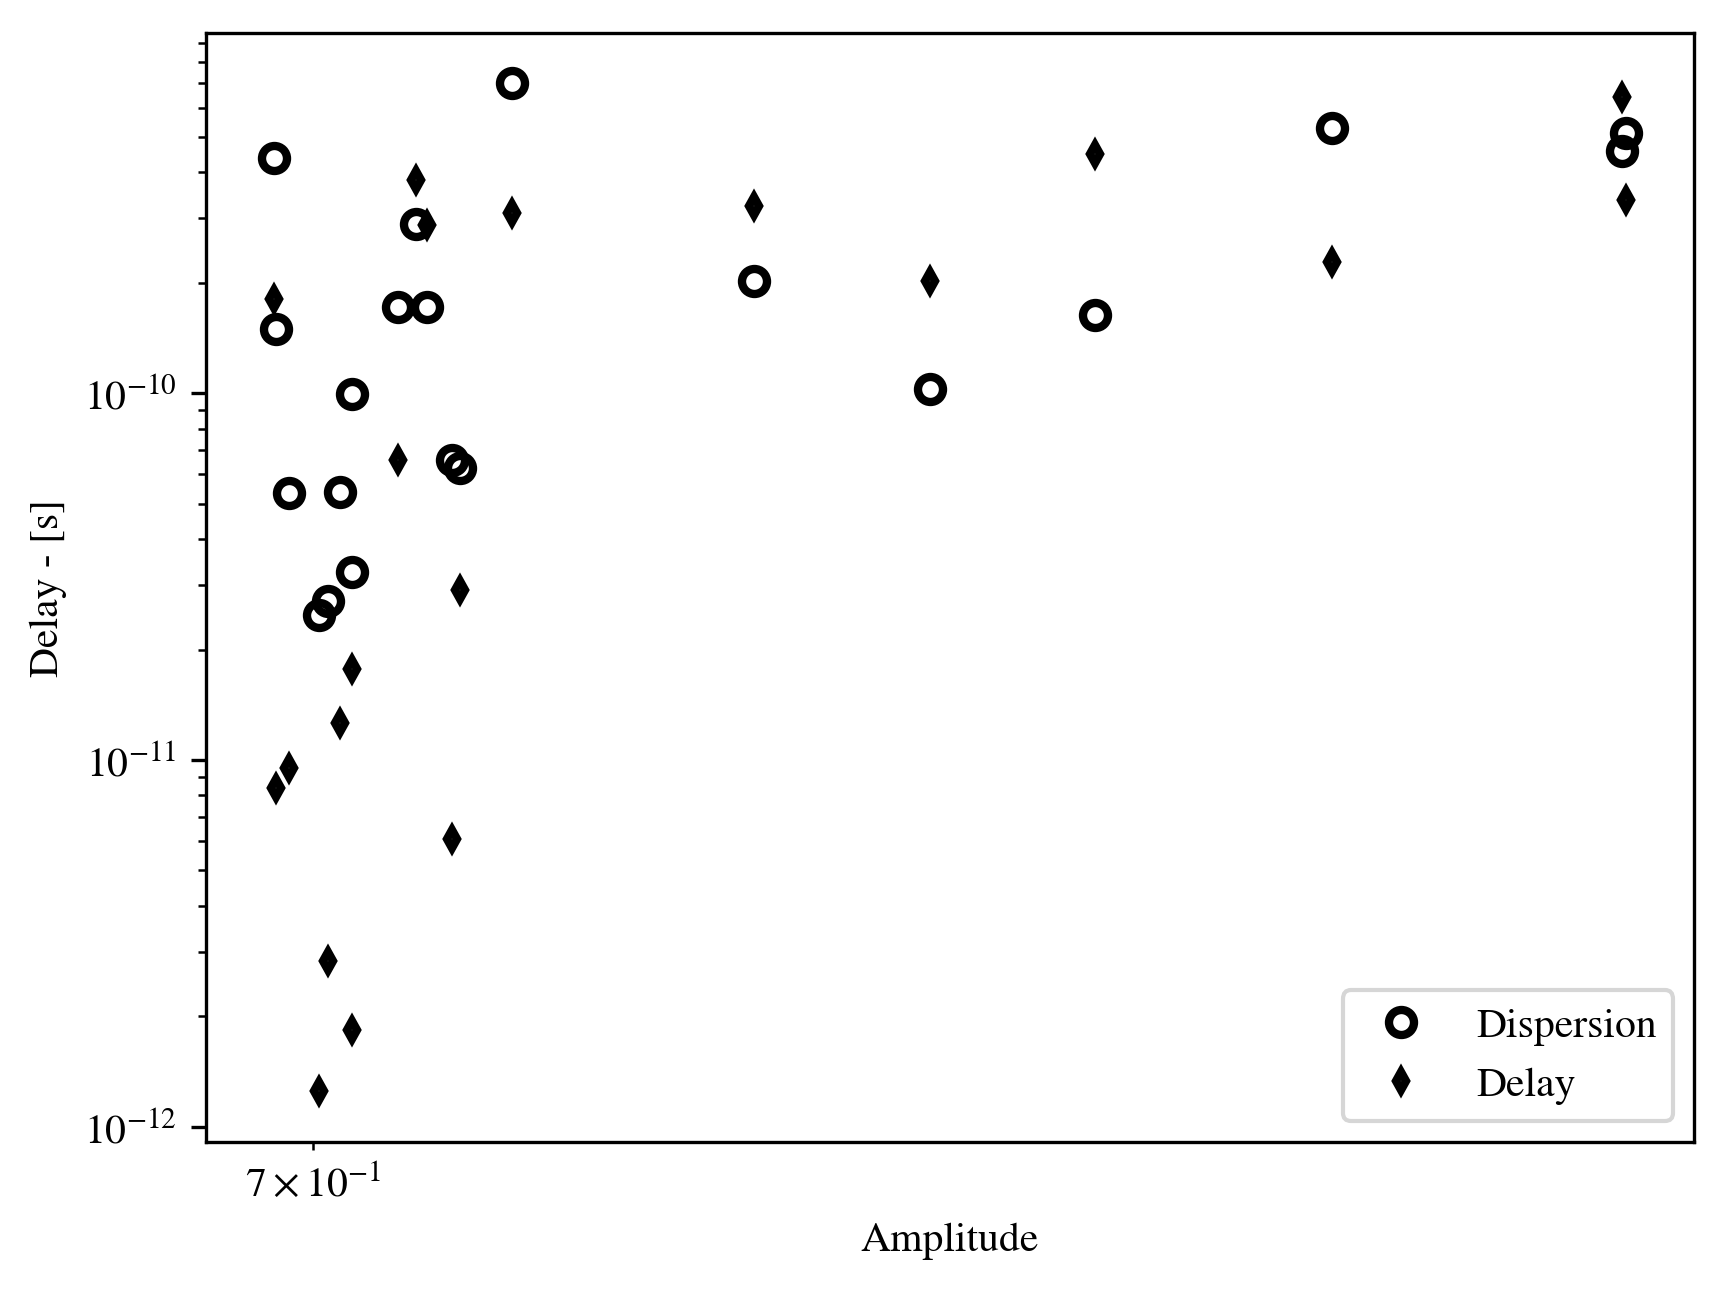

In [25]:
rc = {"font.family" : "STIXGeneral", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)

fig, ax = plt.subplots(dpi = 300)
ax.plot(rms, np.std(delay_list, axis = 1), lw = 0, marker = 'o', ms = 6, mfc= 'none', mec = 'k', mew = 2, label = 'Dispersion')
ax.plot(rms, np.std(delay_list_dispersion, axis = 1), lw = 0, marker = 'd', ms = 3, mfc= 'none', mec = 'k', mew = 2, label = 'Delay')
# ax.axvline(lcy / L,  ls = '--', color = 'k', lw = 1)
# ax.axvline(lcx / L,  ls = '--', color = 'k', lw = 1)
# ax.text(lcx / L, 3e-9, '$\\delta n_{xc}$', fontsize = 12, ha = 'center', backgroundcolor = 'w', rotation = 90 )
# ax.text(lcy / L, 3e-9, '$\\delta n_{yc}$', fontsize = 12, ha = 'center', backgroundcolor = 'w', rotation = 90)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Amplitude')
ax.set_ylabel('Delay - [s]')

ax.legend()